In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Github_notebooks/Tests/multivariate-weather-data-clustering-main.zip

Archive:  /content/drive/MyDrive/Github_notebooks/Tests/multivariate-weather-data-clustering-main.zip
5b62d1afad6c4cc801357e9c47185da73a08f37e
   creating: multivariate-weather-data-clustering-main/
  inflating: multivariate-weather-data-clustering-main/.DS_Store  
  inflating: multivariate-weather-data-clustering-main/.gitignore  
   creating: multivariate-weather-data-clustering-main/Benchmark/
  inflating: multivariate-weather-data-clustering-main/Benchmark/.DS_Store  
   creating: multivariate-weather-data-clustering-main/Benchmark/Affinity_Propagation/
  inflating: multivariate-weather-data-clustering-main/Benchmark/Affinity_Propagation/Affinity_Propagation_PCA11_Norm.ipynb  
   creating: multivariate-weather-data-clustering-main/Benchmark/Dbscan/
  inflating: multivariate-weather-data-clustering-main/Benchmark/Dbscan/Git_testing_DBscan_SST_only.ipynb  
  inflating: multivariate-weather-data-clustering-main/Benchmark/Dbscan/Git_testing_DBscan_all_variables_.ipynb  
  inflating: mu

In [ ]:
!mv multivariate-weather-data-clustering-main multivariateweatherdataclusteringmain

In [ ]:
!pip install "dask[dataframe]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

In [ ]:
path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily_smalldomain.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly_smalldomain.nc')
data = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
#data = xr.open_dataset(path2)# decode_times=False) #To view the date as integers of 0, 1, 2,....
#data5 = xr.open_dataset(path2) # To view time in datetime format
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster

# from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import normalized_mutual_info_score
# from sklearn.metrics import *


from multivariateweatherdataclusteringmain.MWDC.preprocessing import *


def st_agglomerative(input,n, K, affinity, linkage, p, **kwargs):
  '''
  input parameters:

        input: 4-d spatio-temporal xarray

        k : interger, The number of our desired clusters

        proximity: function, The distance metric

        linkage: function, Linkage criteria

        n: Integer Number of principal components
        p: int, (optional) The p parameter for truncate_mode.

  Output:
         
        formed_clusters: 1-D array of cluster labels classifying each data point along the time dimension
                         to a cluster label

        A dataframe showing each cluster label and the correcponding cluster size.

        A dendrogram showing the steps in clustering
     
  '''


  #calling function that transforms our data
  trans_data = datatransformation(input)

  #Normalize data
  norm_data = datanormalization(trans_data)

  #High dimension reduction
  pca1(norm_data,n)

  def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
  
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float)
    
    # Plot the corresponding dendrogram
    
    dendrogram(linkage_matrix, **kwargs)

  #List of algorithms
  clustering_algorithms = (
      ('Single Linkage', 'single'),
      ('Average Linkage', 'average'),
      ('Complete Linkage', 'complete'),
      ('Ward Linkage', 'ward'))
  
  #distance metrics
  affinity_metrics = ['cosine', 'euclidean', 'manhattan']

  for metric in affinity_metrics:
    for alg_name, alg in clustering_algorithms:
      if alg == 'ward' and metric != 'euclidean': continue
      model = AgglomerativeClustering(n_clusters=K, affinity=metric, linkage=alg, compute_distances=True)
  
      #model.fit(data)
      y_model = model.fit(norm_data)
      labels = y_model.labels_

      df1 = pd.DataFrame(norm_data)
      df1['Cluster'] = labels
      df1['Cluster'].value_counts()


      #print("Estimated number of clusters: %d" % n_clusters_)
      print(df1['Cluster'].value_counts())

    # graph size
      plt.figure(1, figsize = (24 ,12))
      
      # plot the top four levels of the dendrogram
      #No more than p levels of the dendrogram tree are displayed. A “level” includes all nodes with p merges from the last merge.
      plot_dendrogram(model, truncate_mode='level',p = 7, get_leaves=True, orientation='top', labels=None) 

    #plt.axhline(y = 85, color='orange', linestyle ="--")

      var = list(data.variables)

      plt.title('Hierarchical Clustering Dendrogram: ' + alg_name + ", " + metric)
      plt.xlabel('Sequence of Merges along the Time component - in Days')
      plt.ylabel(metric + " " +'distance')
      plt.show()

  return df1,labels

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


2    358
0      2
3      1
6      1
5      1
4      1
1      1
Name: Cluster, dtype: int64


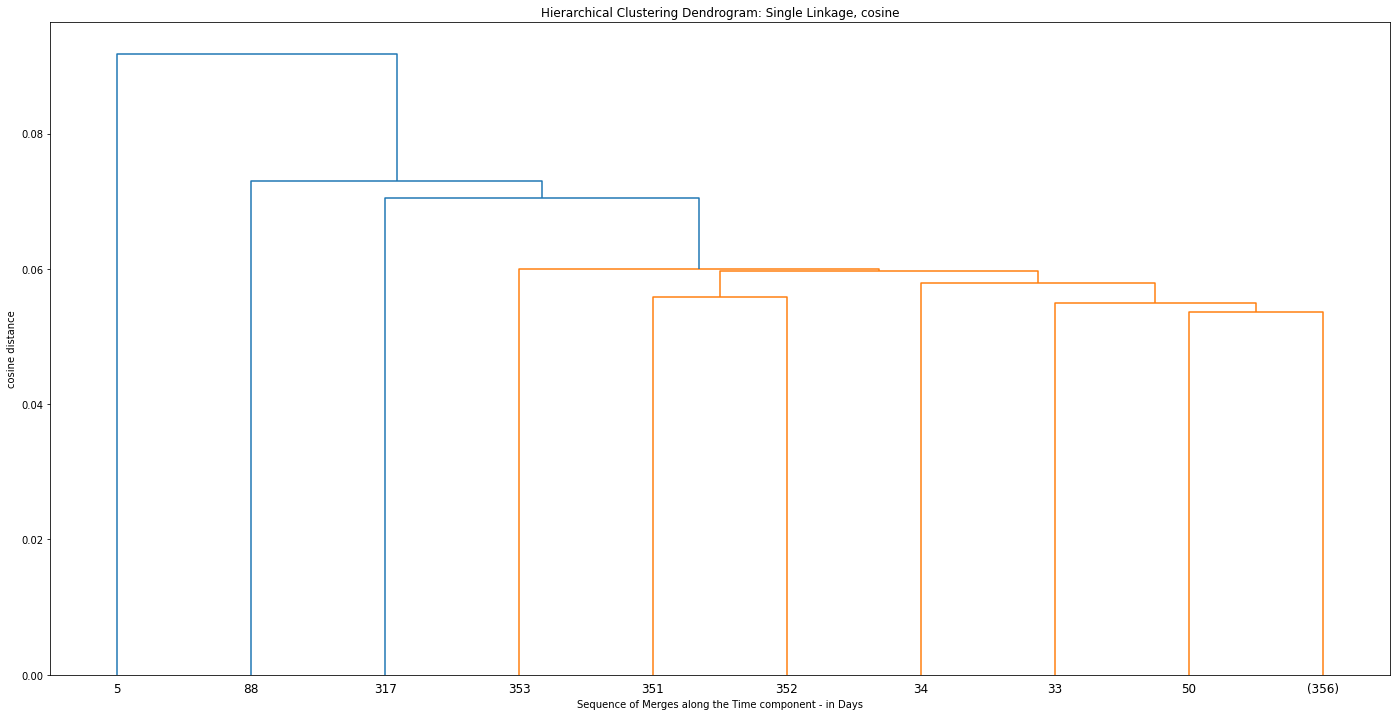

1    339
2     12
0      9
6      2
5      1
3      1
4      1
Name: Cluster, dtype: int64


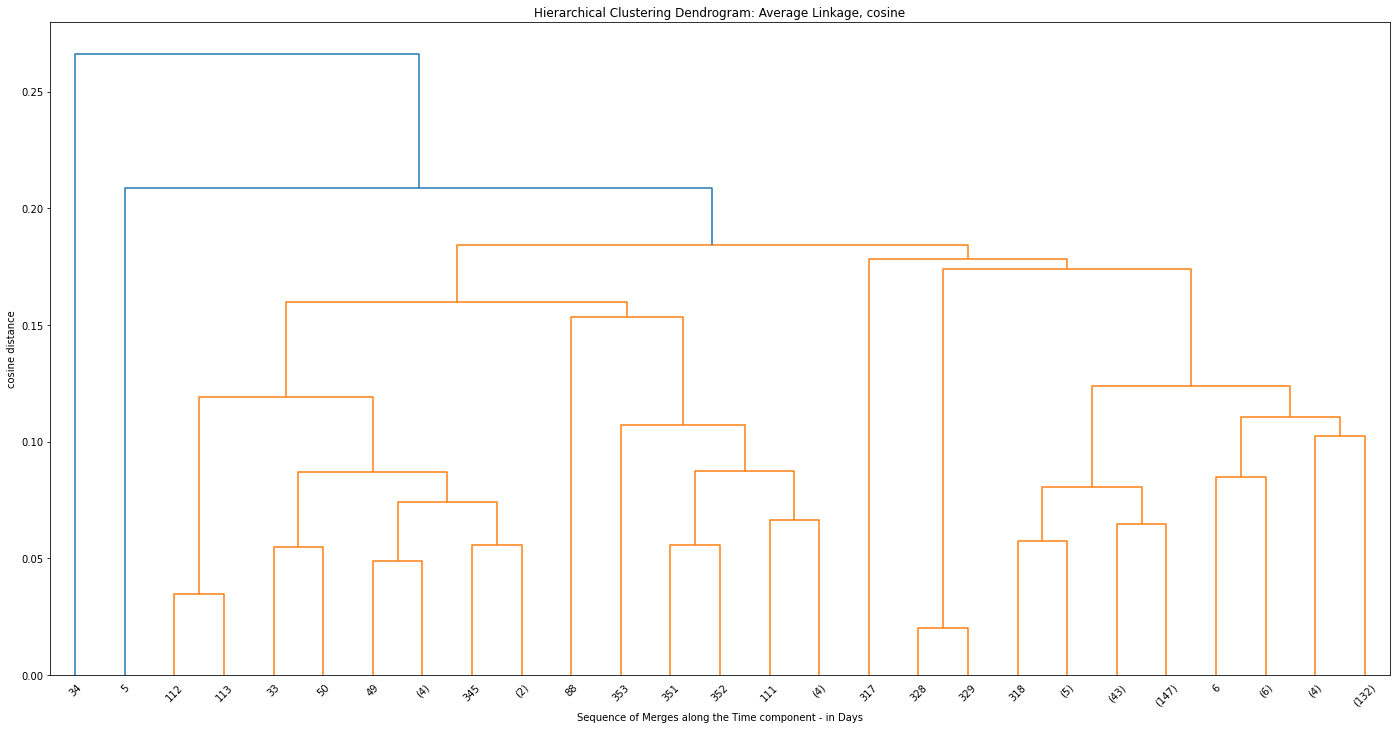

0    153
3    112
1     71
5     10
2      8
6      8
4      3
Name: Cluster, dtype: int64


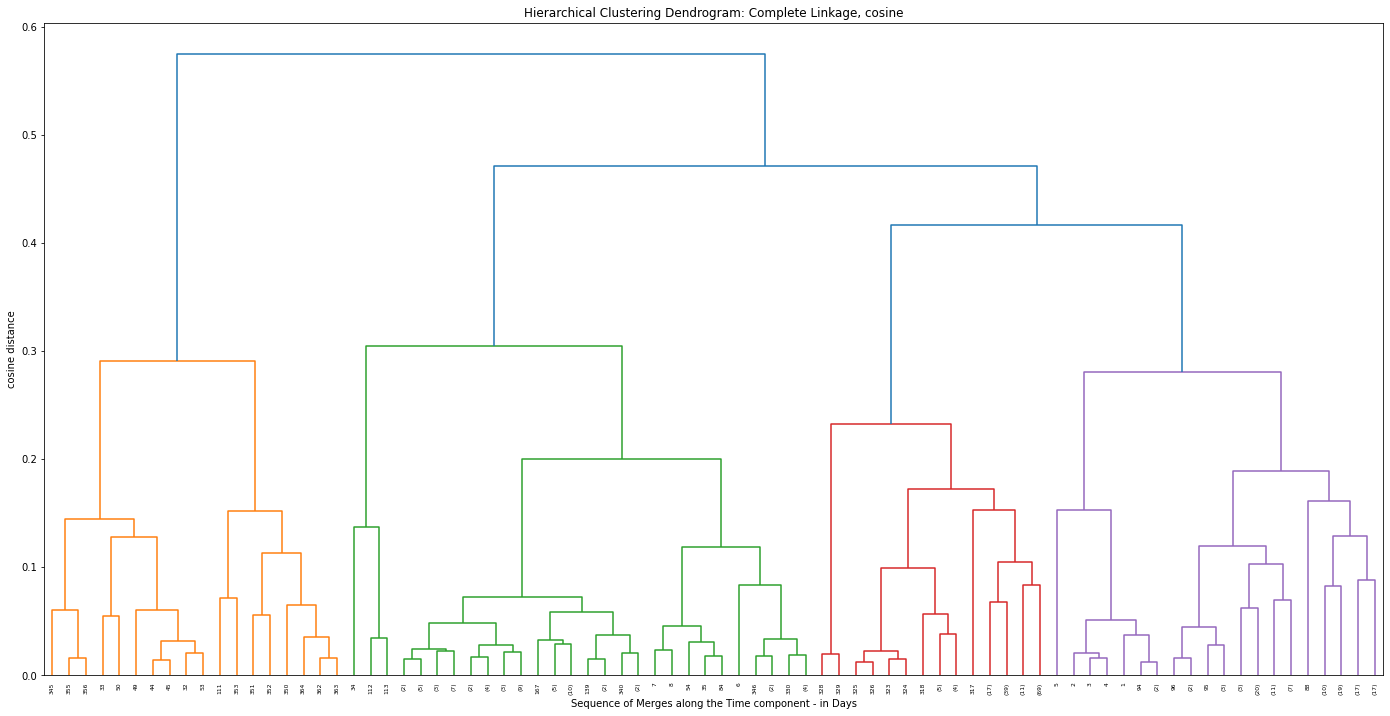

2    355
1      3
0      3
3      1
4      1
5      1
6      1
Name: Cluster, dtype: int64


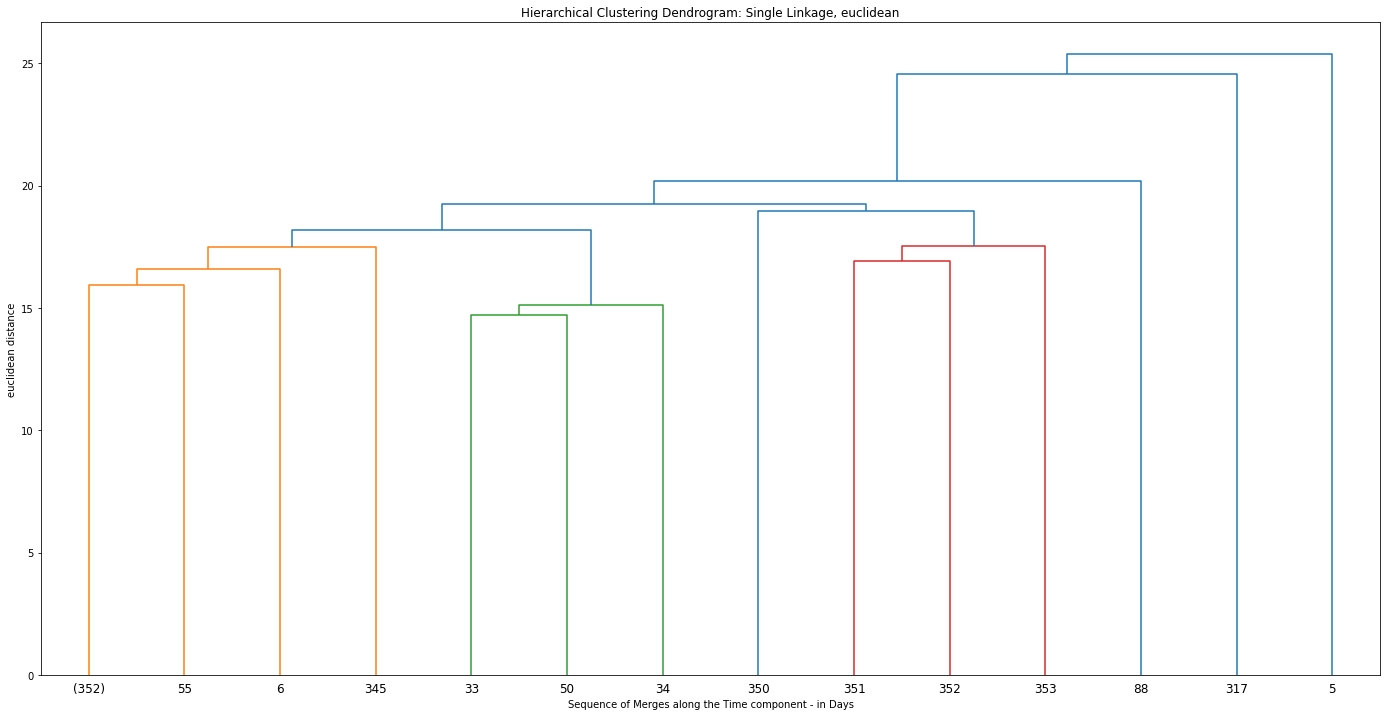

2    195
1    143
5     13
3      8
0      4
6      1
4      1
Name: Cluster, dtype: int64


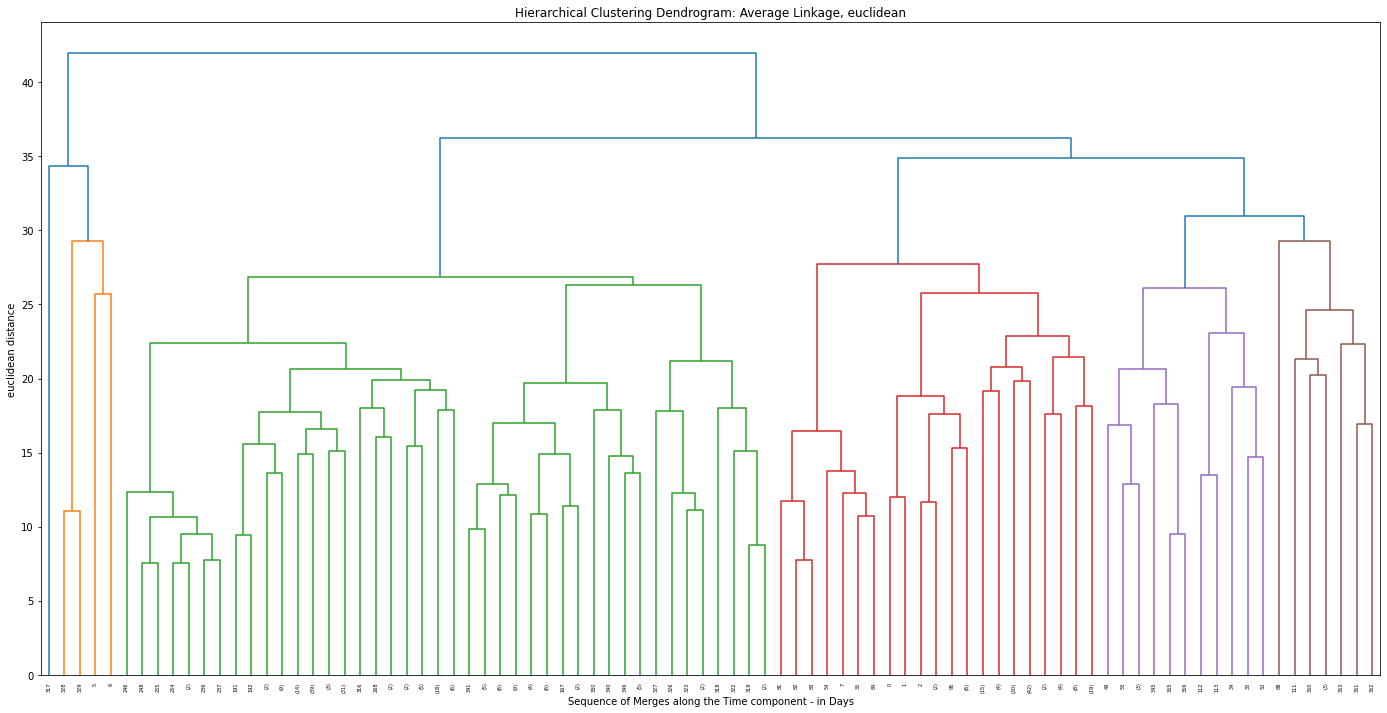

5    142
6     73
3     70
2     38
1     18
4     15
0      9
Name: Cluster, dtype: int64


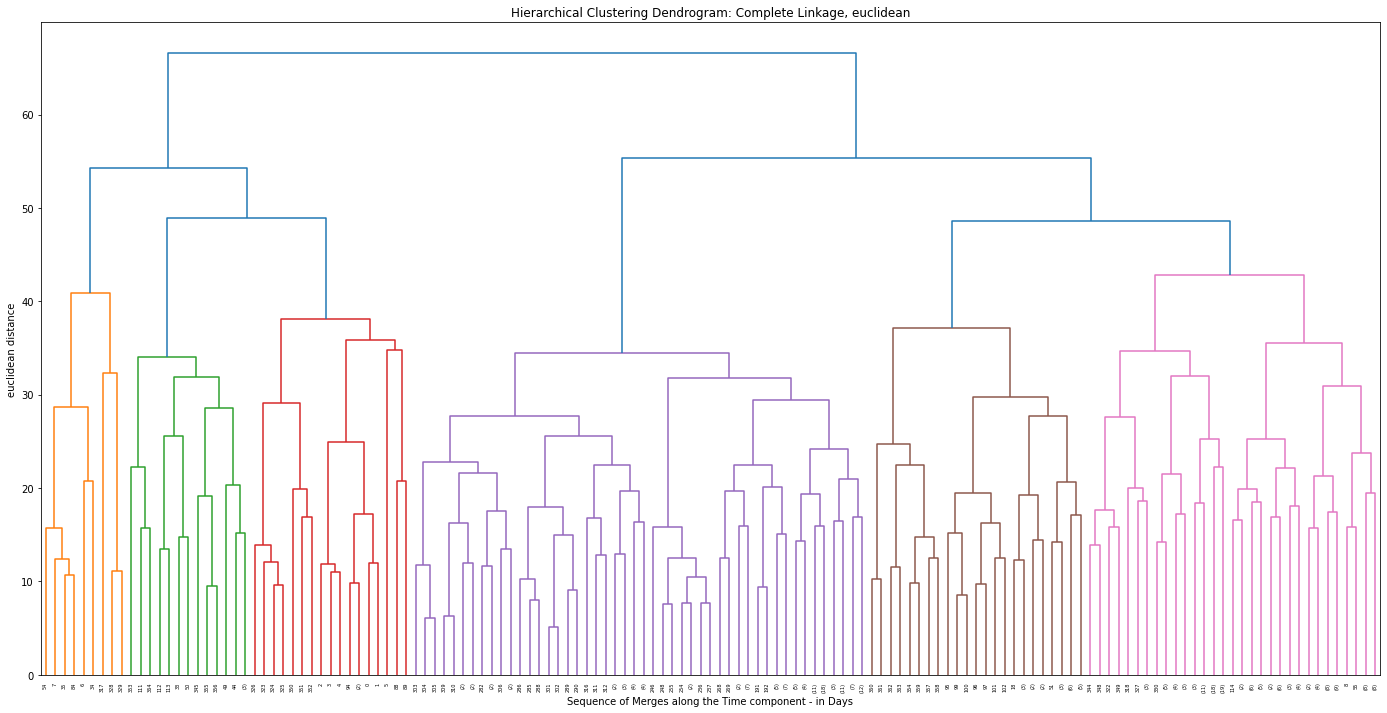

0    112
4     96
1     58
6     34
5     27
2     20
3     18
Name: Cluster, dtype: int64


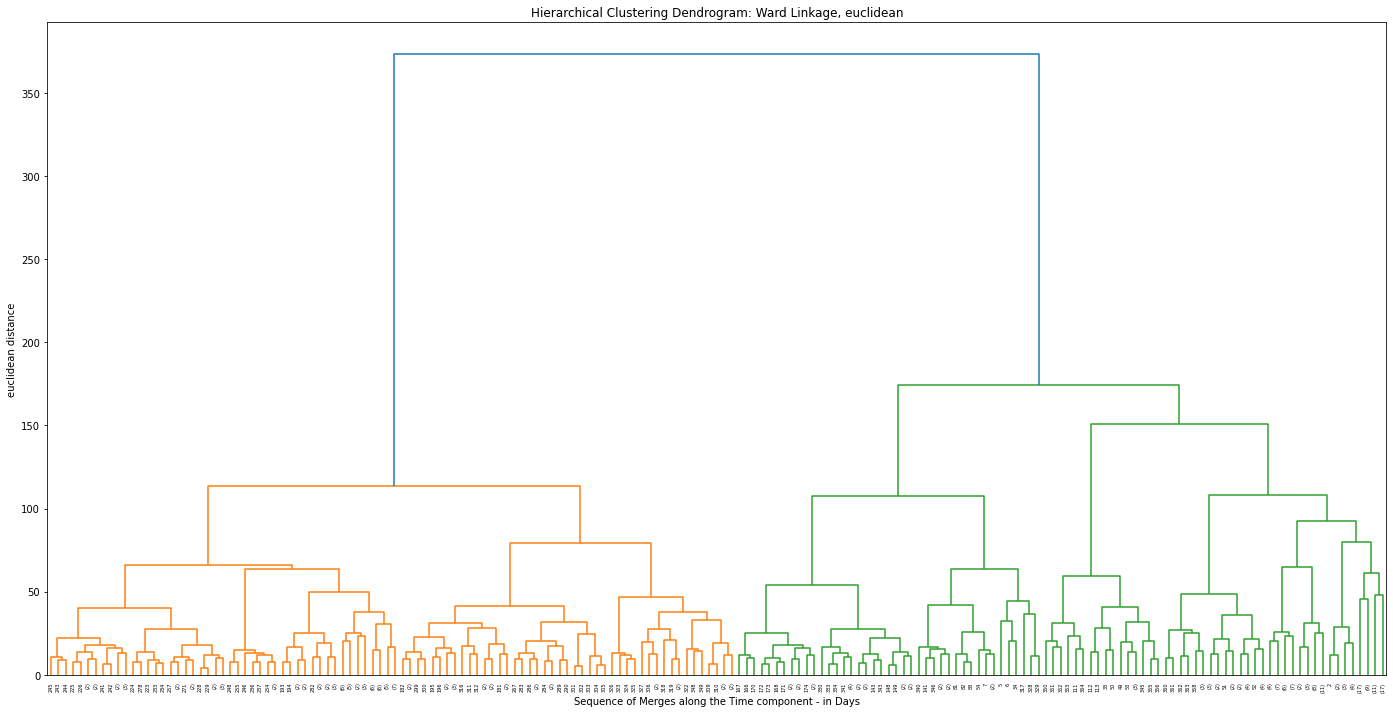

0    355
2      3
1      3
5      1
3      1
4      1
6      1
Name: Cluster, dtype: int64


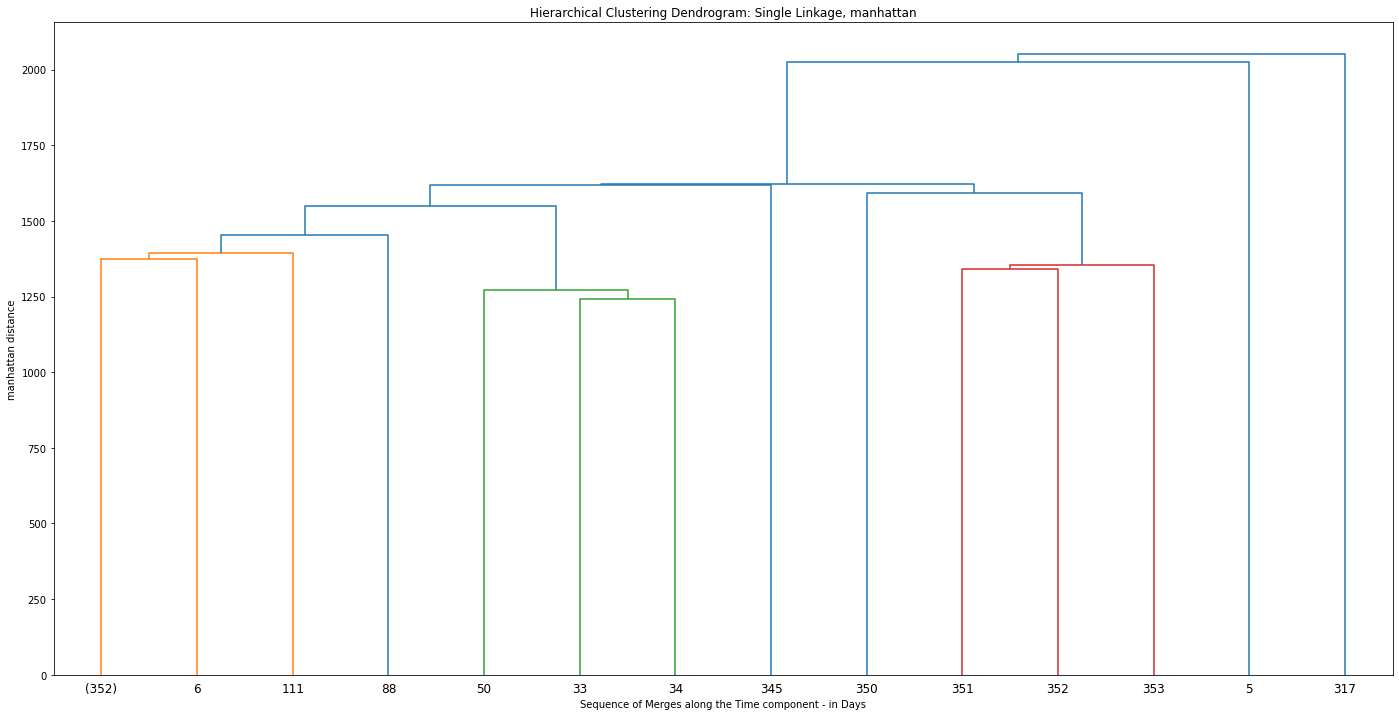

2    179
1    152
0     15
6     13
5      3
4      2
3      1
Name: Cluster, dtype: int64


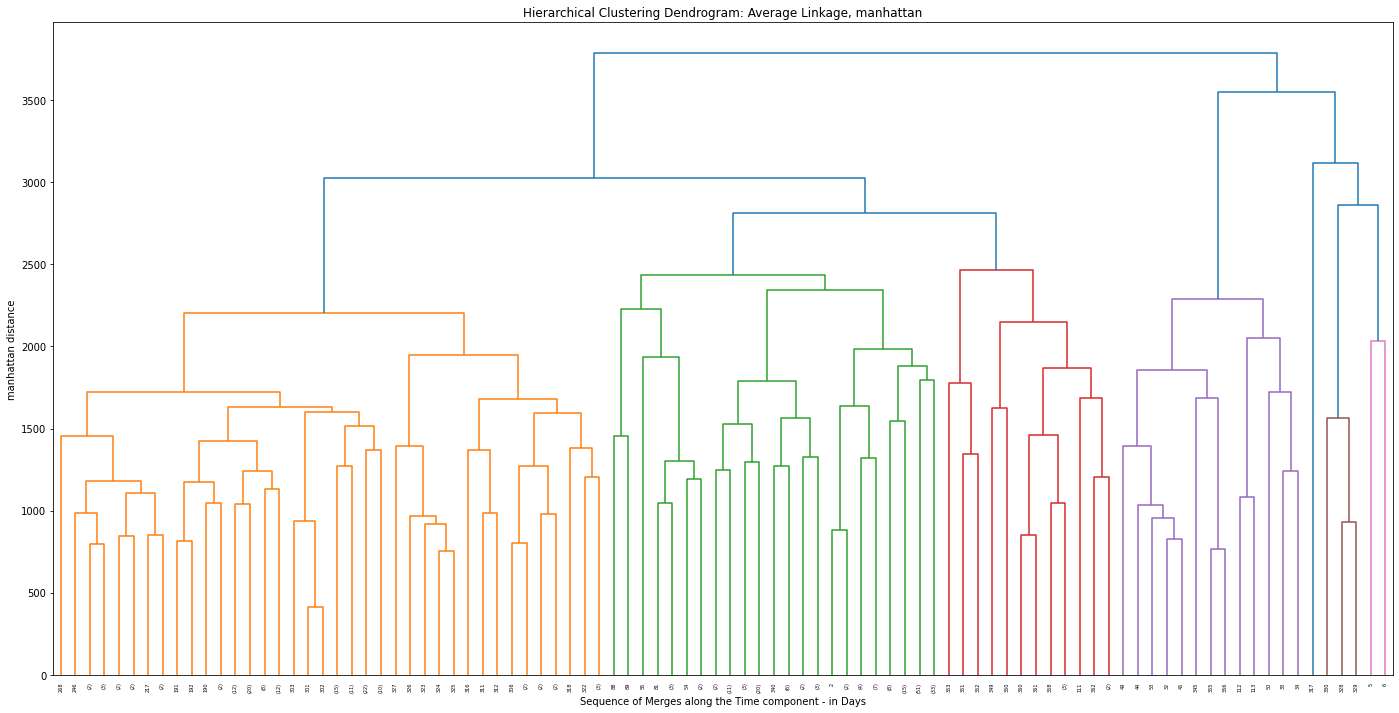

3    138
2     84
0     84
6     25
1     16
5     12
4      6
Name: Cluster, dtype: int64


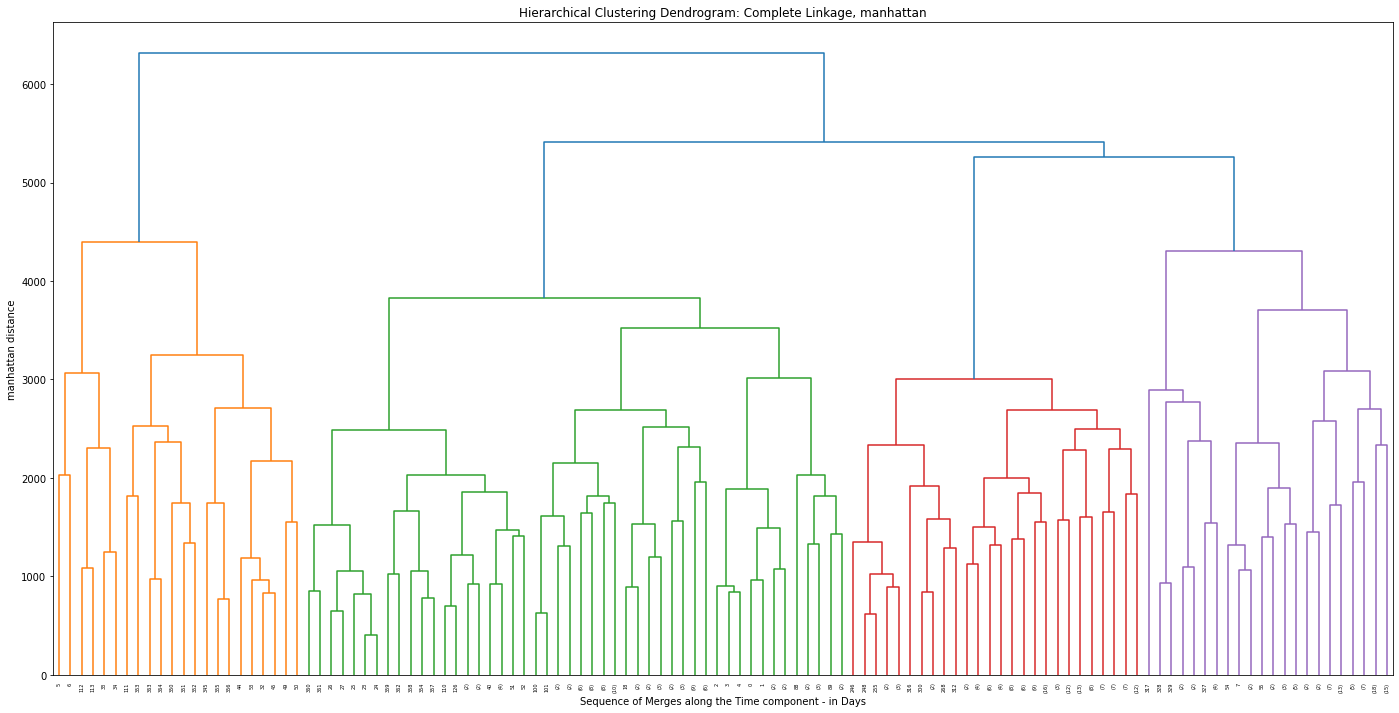

(       sp(43.0,-33.0)  sp(42.75,-33.0)  sp(42.5,-33.0)  sp(42.25,-33.0)  \
 0.0          0.769017         0.763551        0.758399         0.754214   
 1.0          0.550508         0.539280        0.528615         0.520168   
 2.0          0.406872         0.391876        0.377439         0.365852   
 3.0          0.305465         0.282306        0.260121         0.241803   
 4.0          0.421539         0.398652        0.376436         0.357109   
 ...               ...              ...             ...              ...   
 360.0        0.052561         0.047201        0.044078         0.046307   
 361.0        0.000000         0.000000        0.001187         0.007059   
 362.0        0.062689         0.061612        0.062288         0.067914   
 363.0        0.013697         0.005919        0.000000         0.000000   
 364.0        0.153705         0.148152        0.143691         0.143785   
 
        sp(42.0,-33.0)  sp(41.75,-33.0)  sp(41.5,-33.0)  sp(41.25,-33.0)  \
 0.0      

In [ ]:
st_agglomerative(data, 7, 7, p=7, affinity="euclidean", linkage="average")